In [61]:
import numpy as np
from matplotlib import pyplot as plt

In [97]:
import numpy as np

def read_dca1000(file_name, num_adc_samples = 256, num_adc_bits = 16, num_rx = 4):
    """
    Reads the binary file produced by the DCA1000 and Mmwave Studio.
    
    Args:
        file_name (str): Path to the .bin file.
        
    Returns:
        np.ndarray: A numpy array of shape (numRX, numChirps * numADCSamples) containing complex data.
    """
    
    # --- Global Variables (Change based on sensor config) ---
    # num_adc_samples = 256    # number of ADC samples per chirp
    # num_adc_bits = 16        # number of ADC bits per sample
    # num_rx = 4               # number of receivers
    num_lanes = 2            # do not change. number of lanes is always 2
    is_real = False          # set to True if real only data, False if complex data

    # --- Read File ---
    # Read .bin file as int16
    try:
        adc_data = np.fromfile(file_name, dtype=np.int16)
    except FileNotFoundError:
        print(f"Error: File {file_name} not found.")
        return None

    # If 12 or 14 bits ADC per sample compensate for sign extension
    if num_adc_bits != 16:
        l_max = 2**(num_adc_bits-1) - 1
        adc_data[adc_data > l_max] -= 2**num_adc_bits

    file_size = adc_data.size

    # --- Process Data ---
    if is_real:
        # Real data reshape
        num_chirps = file_size // (num_adc_samples * num_rx)
        
        # Reshape to match MATLAB's column-major (F) logic
        lvds = adc_data.reshape(num_adc_samples * num_rx, num_chirps, order='F')
        lvds = lvds.T 
    else:
        # Complex data
        # File size is halved because 2 integers make 1 complex number
        num_chirps = file_size // (2 * num_adc_samples * num_rx)
        
        # The DCA1000 usually interleaves data in a specific pattern for 2 lanes:
        # [Real1, Real2, Imag1, Imag2, Real3, Real4, Imag3, Imag4...]
        # We reshape to (-1, 4) to separate these chunks
        adc_data = adc_data.reshape(-1, 4)
        
        # Construct complex data
        # Real parts are columns 0 and 1; Imaginary parts are columns 2 and 3
        data_real = adc_data[:, [0, 1]].flatten()
        data_imag = adc_data[:, [2, 3]].flatten()
        complex_data = data_real + 1j * data_imag
        
        # Reshape to dimensions: (SamplesPerChirp * NumRX) x NumChirps
        # We use order='F' to mimic MATLAB's default column-filling behavior
        lvds = complex_data.reshape(num_adc_samples * num_rx, num_chirps, order='F')
        
        # Transpose to get (NumChirps) x (SamplesPerChirp * NumRX)
        lvds = lvds.T

    # --- Organize Data per RX ---
    # Currently, lvds shape is (num_chirps, num_rx * num_adc_samples)
    # The columns are packed as: [RX1_Samples | RX2_Samples | RX3_Samples | RX4_Samples]
    
    # 1. Reshape to separate RX channels: (NumChirps, NumRX, NumSamples)
    lvds = lvds.reshape(num_chirps, num_rx, num_adc_samples)
    
    # 2. Transpose to bring RX to the front: (NumRX, NumChirps, NumSamples)
    lvds = lvds.transpose(1, 0, 2)
    
    # 3. Flatten the last two dimensions to get continuous samples per RX
    # Final Shape: (NumRX, NumChirps * NumSamples)
    ret_val = lvds.reshape(num_rx, -1)

    return ret_val

# Example Usage:
# radar_data = read_dca1000('adc_data.bin')
# print(radar_data.shape)

In [148]:
fileName="Sitting1Tx1Rx/static_sitting_Raw_0.bin"
dca_out=read_dca1000(fileName, num_rx=1)

In [149]:
print(dca_out)
print(dca_out.shape)

[[-211.+141.j    0.  +0.j -208.+107.j ...    0.  +0.j   35.+671.j
     0.  +0.j]]
(1, 33554432)


In [150]:
samples_per_chirp=256
no_of_frames=8
chirp_loops=512
dca_out.shape[1]/samples_per_chirp/chirp_loops/no_of_frames

32.0

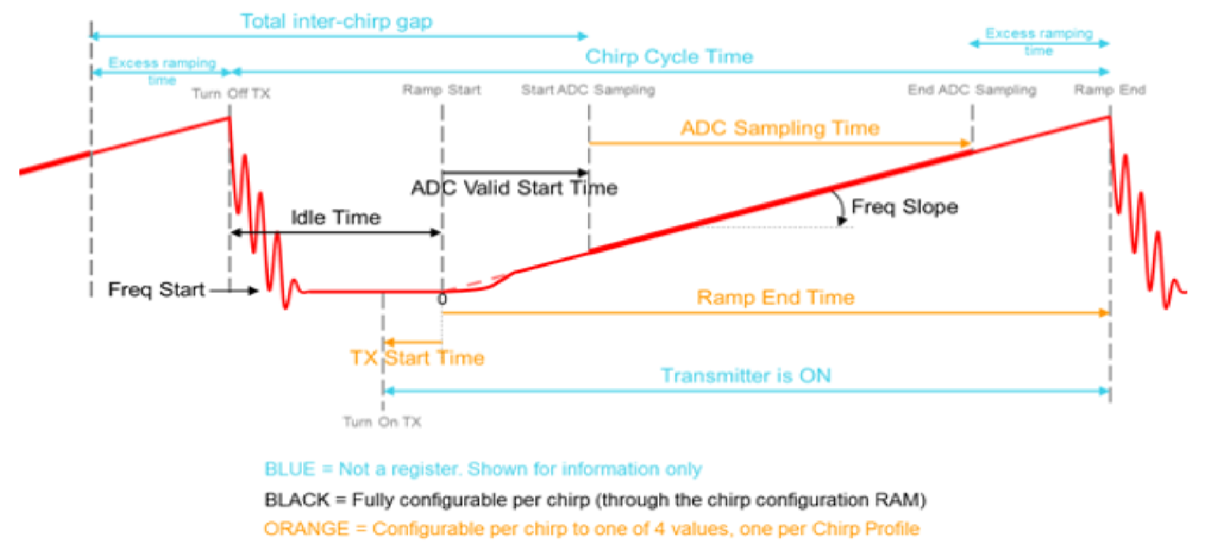

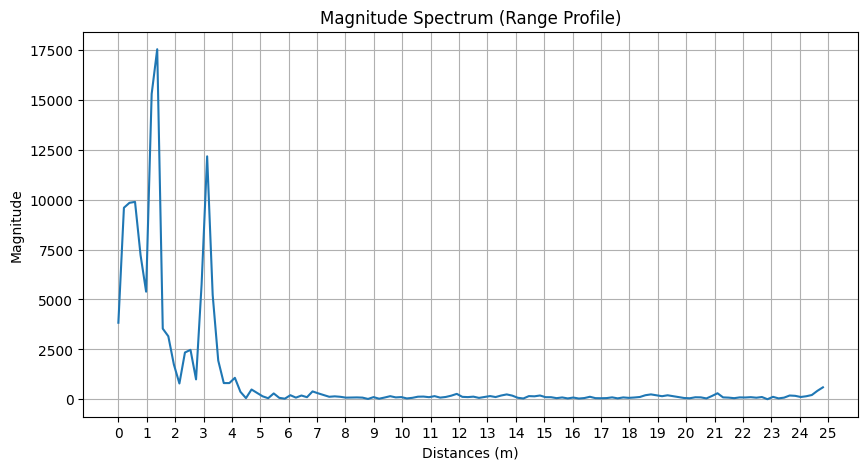

(array([3.83706849e+03, 9.59261131e+03, 9.83982035e+03, 9.88577701e+03,
        7.21803563e+03, 5.39160557e+03, 1.52914578e+04, 1.75276906e+04,
        3.54132200e+03, 3.15975826e+03, 1.74993308e+03, 7.95610137e+02,
        2.34573881e+03, 2.48121132e+03, 1.00119455e+03, 5.74816294e+03,
        1.21665831e+04, 5.22366087e+03, 1.94367193e+03, 8.16489749e+02,
        8.16373374e+02, 1.07896408e+03, 3.79151184e+02, 6.27948828e+01,
        4.94416728e+02, 3.25673954e+02, 1.54141025e+02, 5.77527418e+01,
        2.98178144e+02, 7.69159936e+01, 3.53863546e+01, 2.08492573e+02,
        8.80437998e+01, 1.93205460e+02, 1.09610141e+02, 3.98611545e+02,
        3.04308654e+02, 2.16705530e+02, 1.30794852e+02, 1.52198260e+02,
        1.30022205e+02, 8.72302865e+01, 9.40445670e+01, 9.82007829e+01,
        8.80752937e+01, 2.20719236e+01, 1.13776764e+02, 3.37614252e+01,
        9.35238665e+01, 1.60839676e+02, 9.95898191e+01, 1.14846223e+02,
        4.73693490e+01, 7.81027627e+01, 1.34462369e+02, 1.406197

In [151]:
sampling_frequency = 10000 * 1e3 # Hz (example)
S=29.982 * 1e12 #mhz/us
start_freq=77*1e9
ramp_end=60 #us
idle_time=100 #us
chirp_cycle_time=(idle_time + ramp_end) * 1e-6
pulse_repetation_interval = 1/chirp_cycle_time
num_rx=1
num_chirps=1
samples_per_chirp=256
range_max=3e8*sampling_frequency/(4*S)

def rangeFFT(data, plot=False):
    signal=data[0][:samples_per_chirp]
    num_samples = len(signal)
    window = np.hamming(num_samples)
    signal_windowed = signal * window
    y=np.fft.fft(signal_windowed)
    fft_magnitude=np.abs(y)
    frequencies = np.fft.fftfreq(num_samples, d=1/sampling_frequency)
    distances=frequencies*3e8/2/S

    if plot:
        # Plot the magnitude spectrum
        plt.figure(figsize=(10, 5))
        # plt.plot(frequencies[:num_samples//2], fft_magnitude[:num_samples//2]) # Plot only positive frequencies
        plt.plot(distances[:num_samples//2], fft_magnitude[:num_samples//2]) # Plot only positive frequencies
        plt.title('Magnitude Spectrum (Range Profile)')
        # plt.xlabel('Frequency (Hz) / Range Bins')
        plt.xlabel('Distances (m)')
        plt.ylabel('Magnitude')
        plt.xticks(np.arange(0,range_max,1))
        plt.grid(True)
        plt.show()
    return fft_magnitude, frequencies, distances
    
    
rangeFFT(dca_out, plot=True)

In [176]:
def generateDataCube(data, samples_per_chirp, num_chirps):
    data_cube=np.zeros([num_chirps, samples_per_chirp],dtype=np.complex128)
    for i in range(num_chirps):
        data_cube[i,:]=data[i*samples_per_chirp:(i+1)*samples_per_chirp]
    return data_cube
cube=generateDataCube(dca_out[0], 256, 512)

In [177]:
cube.shape

(512, 256)

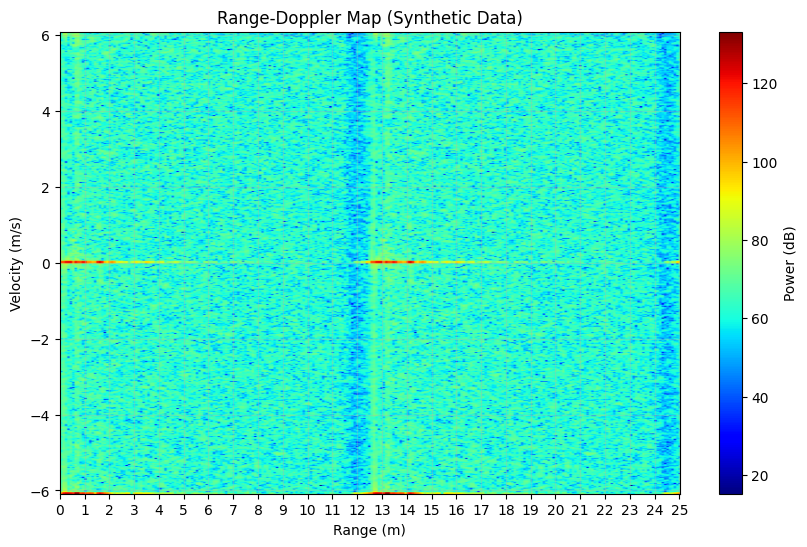

In [178]:


def process_range_doppler(radar_data):
    """
    Performs Range FFT followed by Doppler FFT.
    """
    num_chirps, num_samples = radar_data.shape
    
    # --- Step 1: Windowing (Optional but recommended to reduce leakage) ---
    # Window across samples (Fast Time)
    win_range = np.hanning(num_samples)
    # Window across chirps (Slow Time)
    win_doppler = np.hanning(num_chirps)
    
    # Apply windows (broadcasting)
    data_windowed = radar_data * win_range[np.newaxis, :] * win_doppler[:, np.newaxis]

    # --- Step 2: Range FFT (Fast Time - Axis 1) ---
    range_fft = np.fft.fft(data_windowed, axis=1)
    
    # --- Step 3: Doppler FFT (Slow Time - Axis 0) ---
    # We usually take the FFT across the chirps for every range bin
    doppler_fft = np.fft.fft(range_fft, axis=0)
    
    # --- Step 4: Shift and Log Scale ---
    # Shift zero frequency to center for Doppler
    doppler_fft_shifted = np.fft.fftshift(doppler_fft, axes=0)
    
    # Convert to dB
    rd_map_db = 20 * np.log10(np.abs(doppler_fft_shifted) + 1e-9) # 1e-9 prevents log(0)
    
    return rd_map_db

# --- Main Execution ---

# 1. Setup Dimensions
N_CHIRPS = 128
N_SAMPLES = 256
c=3e8
# 3. Process
rd_map = process_range_doppler(cube)

# 4. Calculate Axis Extents for Plotting
# Max Range = c * SampleRate / (2 * Slope) ... simplified here for display:
fs = sampling_frequency
slope = S
max_range = (c * fs) / (2 * slope) / 2 # Divide by 2 because of complex FFT mirror or Nyquist
max_velocity = (c / start_freq) / (4 * chirp_cycle_time)

# 5. Visualization
plt.figure(figsize=(10, 6))
# Extent format: [left, right, bottom, top] -> [Range 0 to Max, Vel -Max to +Max]
# Note: Usually Range is X or Y depending on preference. Here Range is X-axis.
plt.imshow(rd_map, aspect='auto', cmap='jet', 
           extent=[0, max_range, -max_velocity, max_velocity], origin='lower')
plt.xticks(np.arange(0,max_range,1))
plt.title('Range-Doppler Map (Synthetic Data)')
plt.xlabel('Range (m)')
plt.ylabel('Velocity (m/s)')
plt.colorbar(label='Power (dB)')
plt.grid(alpha=0.3)
plt.show()

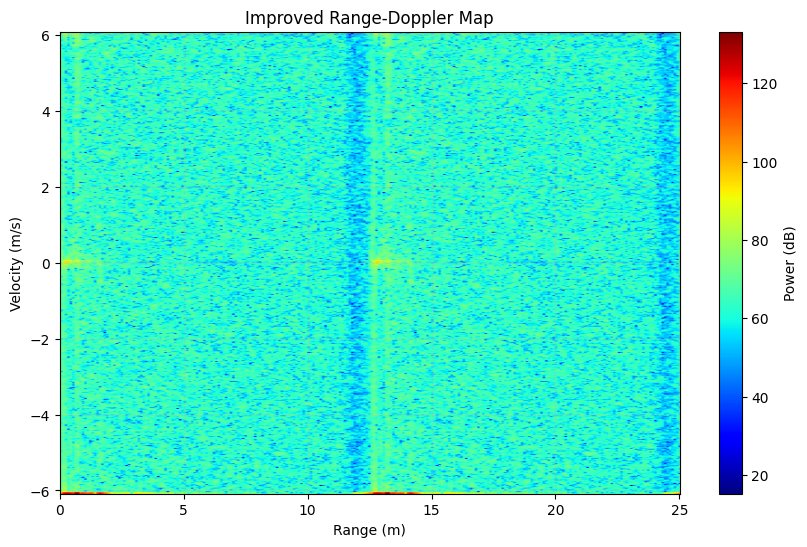

In [183]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

def process_range_doppler(radar_data):
    """
    radar_data: complex numpy array shaped (num_chirps, num_samples)
    Returns: Range-Doppler map (dB), and Doppler FFT shifted
    """

    num_chirps, num_samples = radar_data.shape

    # ----------------------------------------------------
    # 1. Windowing
    # ----------------------------------------------------
    win_range = np.hanning(num_samples)              # fast-time window
    win_doppler = np.hanning(num_chirps)             # slow-time window

    # ----------------------------------------------------
    # 2. Range FFT
    # ----------------------------------------------------
    data_win_range = radar_data * win_range[np.newaxis, :]
    range_fft = np.fft.fft(data_win_range, axis=1)

    # ----------------------------------------------------
    # 3. Clutter Removal (DC removal along chirps)
    # ----------------------------------------------------
    # Removes static objects & prevents doppler edge artifacts
    range_fft = range_fft - np.mean(range_fft, axis=0, keepdims=True)

    # Optional: FIR high-pass (MTI) for even better clutter suppression
    # b = [1, -1]
    # a = [1]
    # range_fft = lfilter(b, a, range_fft, axis=0)

    # ----------------------------------------------------
    # 4. Doppler FFT
    # ----------------------------------------------------
    range_fft_win = range_fft * win_doppler[:, np.newaxis]
    doppler_fft = np.fft.fft(range_fft_win, axis=0)
    doppler_fft_shifted = np.fft.fftshift(doppler_fft, axes=0)

    # ----------------------------------------------------
    # 5. Magnitude (dB)
    # ----------------------------------------------------
    rd_map_db = 20 * np.log10(np.abs(doppler_fft_shifted) + 1e-9)

    return rd_map_db, doppler_fft_shifted


# =====================================================================
# Main Execution
# =====================================================================

# Radar constants (you already have these defined)
c = 3e8
fs = sampling_frequency           # ADC sampling freq
slope = S                         # FMCW slope (Hz/s)
f_start = start_freq              # Start freq (Hz)
T_chirp = chirp_cycle_time        # Chirp duration (sec)

# Data dimensions
N_CHIRPS, N_SAMPLES = cube.shape

# Generate RD Map
rd_map, dop_fft = process_range_doppler(cube)

# =====================================================================
# Create Range & Doppler Axes
# =====================================================================

# --- Range axis ---
max_range = (c * fs) / (4 * slope)
range_axis = np.linspace(0, max_range, N_SAMPLES)

# --- Doppler axis ---
lambda_c = c / f_start
max_velocity = lambda_c / (4 * T_chirp)
doppler_axis = np.linspace(-max_velocity, max_velocity, N_CHIRPS)

# =====================================================================
# Plot
# =====================================================================

plt.figure(figsize=(10, 6))
plt.imshow(rd_map,
           aspect='auto',
           cmap='jet',
           extent=[range_axis[0], range_axis[-1],
                   doppler_axis[0], doppler_axis[-1]],
           origin='lower')

plt.title('Improved Range-Doppler Map')
plt.xlabel('Range (m)')
plt.ylabel('Velocity (m/s)')
plt.colorbar(label='Power (dB)')
plt.grid(alpha=0.25)
plt.show()
